In [3]:
# Loading necessary modules
import pandas as pd
from wordcloud import STOPWORDS, WordCloud
from gensim.models import CoherenceModel
from gensim import corpora
from pprint import pprint
import string
import gensim
from gensim.utils import simple_preprocess
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')

In [4]:
tweet_data = pd.read_csv('processed_tweet_data.csv')
tweet_data.head(6)

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,Fri Jun 18 17:55:49 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...","🚨Africa is ""in the midst of a full-blown third...",0.166667,0.188889,en,548,612,ketuesriche,551,351,NaN,[],"[{'screen_name': 'TelGlobalHealth', 'name': 'T...",Mass
1,Fri Jun 18 17:55:59 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...","Dr Moeti is head of WHO in Africa, and one of ...",0.133333,0.455556,en,195,92,Grid1949,66,92,NaN,[],"[{'screen_name': 'globalhlthtwit', 'name': 'An...","Edinburgh, Scotland"
2,Fri Jun 18 17:56:07 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",Thank you @research2note for creating this ama...,0.316667,0.483333,en,2,1,LeeTomlinson8,1195,1176,NaN,"[{'text': 'red4research', 'indices': [103, 116]}]","[{'screen_name': 'NHSRDForum', 'name': 'NHS R&...",NaN
3,Fri Jun 18 17:56:10 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...","Former Pfizer VP and Virologist, Dr. Michael Y...",0.086111,0.197222,en,1580,899,RIPNY08,2666,2704,NaN,[],"[{'screen_name': 'HighWireTalk', 'name': 'The ...",NaN
4,Fri Jun 18 17:56:20 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",I think it’s important that we don’t sell COVA...,0.280000,0.620000,en,72,20,pash22,28250,30819,NaN,[],"[{'screen_name': 'PeterHotez', 'name': 'Prof P...",United Kingdom
5,Fri Jun 18 17:56:25 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",I’m pleased to welcome the #WeCanDoThis bus to...,0.508333,0.783333,en,683,220,SandhraLee,759,4163,NaN,"[{'text': 'WeCanDoThis', 'indices': [44, 56]},...","[{'screen_name': 'CDCDirector', 'name': 'Roche...",USA


In [5]:
# Data cleaning

# select only 'original_text' and 'polarity' columns
tweet_data = tweet_data[['original_text', 'polarity']]
# text Preprocessing
tweet_data['original_text']=tweet_data['original_text'].astype(str)

# Convert to lowercase
tweet_data['original_text'] = tweet_data['original_text'].map(lambda x: x.lower())

# Remove punctuation
tweet_data['original_text']= \
tweet_data['original_text'].apply(lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation)))
tweet_data.head(6)

,original_text,polarity
0,🚨africa is in the midst of a fullblown third w...,0.166667
1,dr moeti is head of who in africa and one of t...,0.133333
2,thank you research2note for creating this amaz...,0.316667
3,former pfizer vp and virologist dr michael yea...,0.086111
4,i think it’s important that we don’t sell cova...,0.280000
5,i’m pleased to welcome the wecandothis bus to ...,0.508333


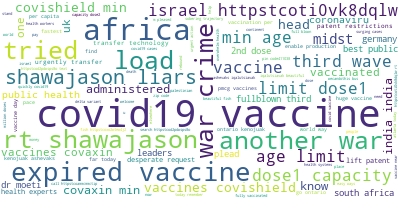

In [6]:
# Exploratory analysis

# Join the different processed titles together.
long_string = ','.join(list(tweet_data['original_text'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=500, contour_width=8, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [7]:
# Preparing data for LDA analysis
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) # deacc=True removes punctuations

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


data = tweet_data.original_text.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

['africa', 'midst', 'fullblown', 'third', 'wave', 'coronavirus', 'head', 'whoafro', 'warned', 'cases', 'risen', 'across', 'continent', 'deaths', 'also', 'risen', 'last', 'week', 'jriggers', 'reports']


In [8]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)]


In [9]:
# LDA model training

# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.040*"vaccines" + 0.029*"covid" + 0.015*"africa" + 0.014*"vaccine" + '
  '0.009*"health" + 0.008*"vaccination" + 0.006*"cases" + 0.006*"amp" + '
  '0.006*"ontario" + 0.006*"doses"'),
 (1,
  '0.044*"vaccines" + 0.026*"africa" + 0.026*"israel" + 0.023*"rt" + '
  '0.022*"another" + 0.022*"expired" + 0.022*"liars" + 0.022*"shawajason" + '
  '0.022*"tried" + 0.021*"war"'),
 (2,
  '0.050*"covid" + 0.037*"vaccines" + 0.014*"dose" + 0.012*"africa" + '
  '0.012*"capacity" + 0.011*"limit" + 0.011*"code" + 0.011*"age" + 0.011*"min" '
  '+ 0.011*"pin"'),
 (3,
  '0.033*"covid" + 0.023*"vaccines" + 0.017*"vaccine" + 0.015*"amp" + '
  '0.013*"code" + 0.010*"dose" + 0.009*"today" + 0.008*"wecandothis" + '
  '0.008*"find" + 0.008*"text"'),
 (4,
  '0.035*"vaccines" + 0.027*"covid" + 0.014*"africa" + 0.013*"risen" + '
  '0.012*"india" + 0.011*"cases" + 0.010*"coronavirus" + 0.010*"people" + '
  '0.010*"deaths" + 0.009*"wave"'),
 (5,
  '0.038*"vaccines" + 0.036*"covid" + 0.019*"vaccine" + 0.012*"

In [10]:
# Analyzing LDA model results

# Compute Perplexity

#It's a measure of how good the model is. The lower the better. Perplexity is a negative value
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
doc_lda = lda_model[corpus]


# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n Ldamodel Coherence Score/Accuracy on Tweets: ', coherence_lda)


Perplexity:  -6.794349425075411

 Ldamodel Coherence Score/Accuracy on Tweets:  0.43387203760393805


In [11]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.098628 -0.028809       1        1  13.230876
7      0.021418  0.161788       2        1  11.737217
2     -0.092283  0.065631       3        1  11.676226
4      0.037229  0.022872       4        1  10.229083
8      0.180632 -0.042317       5        1   9.636467
1      0.215916 -0.021088       6        1   9.160606
5     -0.080408 -0.016669       7        1   9.098799
6     -0.065863 -0.143783       8        1   8.454527
0     -0.041534  0.013362       9        1   8.398842
3     -0.076478 -0.010988      10        1   8.377358, topic_info=            Term        Freq        Total Category  logprob  loglift
1490  httpstcoti  560.000000   560.000000  Default  30.0000  30.0000
1489        dqlw  559.000000   559.000000  Default  29.0000  29.0000
1494          vk  560.000000   560.000000  Default  28.0000  28.0000
1495         war  661.000000   661.000000  Default  27.0000  27.0000
1501  shawajason  657.000000   657.000000  Default  26.0000  26.0000
...          ...         ...          ...      ...      ...      ...
1         africa   66.341365  1519.324360  Topic10  -5.0322  -0.6516
675          age   53.086637   501.020547  Topic10  -5.2551   0.2349
215           rt   56.125397  1000.011385  Topic10  -5.1995  -0.4005
682          min   50.014124   478.766709  Topic10  -5.3147   0.2207
677     capacity   50.105473   534.225307  Topic10  -5.3129   0.1130

[790 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1746      1  0.804866  accelerates
1746      3  0.100608  accelerates
5209      5  0.638380      account
0         1  0.093594       across
0         2  0.011011       across
...     ...       ...          ...
3334      3  0.666190        zweli
3334      4  0.039188        zweli
3334      6  0.019594        zweli
3334      7  0.097969        zweli
3334      8  0.039188        zweli

[2637 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 8, 3, 5, 9, 2, 6, 7, 1, 4])